# Курсовой проект

### Задание:

Используя данные из обучающего датасета (train.csv), построить модель для предсказания цен на недвижимость (квартиры).
С помощью полученной модели, предсказать цены для квартир из тестового датасета (test.csv).

#### Описание датасета:

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [1]:
import random
from datetime import datetime

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

matplotlib.rcParams.update({'font.size': 14})

In [2]:
# функция для проверки параметра r2 для теста и трейна

def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

## 1. Работа с файлами

### Подключение файлов

In [3]:
TRAIN_DATASET_PATH = './project_task/train.csv'
TEST_DATASET_PATH = './project_task/test.csv'

In [4]:
# Загруза данных
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,77,32,2.0,50.401785,30.476203,5.0,6,5.0,1968,0.135650,B,B,46,7960,6,350.0,3,11,B,196684.316040
9996,6159,18,1.0,41.521546,20.539216,9.0,13,13.0,2000,0.000000,B,B,30,5562,0,NaN,0,5,A,189050.289571
9997,5123,27,1.0,47.939008,NaN,1.0,12,16.0,2015,0.072158,B,B,2,629,1,NaN,0,0,A,159143.805370
9998,5400,75,2.0,43.602562,33.840147,8.0,1,5.0,1961,0.307467,B,A,30,5048,9,325.0,2,5,B,181595.339808
9999,6306,128,1.0,38.666645,21.157874,8.0,7,17.0,1990,0.000000,B,B,27,4798,0,30.0,2,8,B,218714.077615


In [5]:
# Типы данных признаков
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [6]:
test_df = pd.read_csv(TEST_DATASET_PATH)

print('Кол-во строк в train:', train_df.shape[0])
print('Кол-во строк в test', test_df.shape[0])

Кол-во строк в train: 10000
Кол-во строк в test 5000


### Приведение типов

In [7]:
# Переводим из числового типа в строковый признаки, значения которых не отображают разницы между ними.

train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

train_df.dtypes

Id                object
DistrictId        object
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

### Оптимизация памяти

In [8]:
def memory_compression(df):
    original_mem = df.memory_usage().sum()/1024**2
    
    for col in df.columns:
        
        if df[col].dtype != object:
            col_min = df[col].min()
            col_max = df[col].max()

            if str(df[col].dtype)[:3] == 'int':
                if col_min > np.iinfo(np.int8).min and col_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif col_min > np.iinfo(np.int16).min and col_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif col_min > np.iinfo(np.int32).min and col_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif col_min > np.iinfo(np.int64).min and col_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            elif str(df[col].dtype)[:5] == 'float':
                if col_min > np.finfo(np.float32).min and col_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')
            
    reduced_mem = df.memory_usage().sum()/1024**2
    
    print(f'Начальный размер памяти: {round(original_mem,2)} мб.')
    print(f'Конечный размер памяти: {round(reduced_mem,2)} мб.')

In [9]:
memory_compression(train_df)
memory_compression(test_df)

Начальный размер памяти: 1.53 мб.
Конечный размер памяти: 0.89 мб.
Начальный размер памяти: 0.72 мб.
Конечный размер памяти: 0.21 мб.


## 2. Анализ данных

### Анализ целевого признака

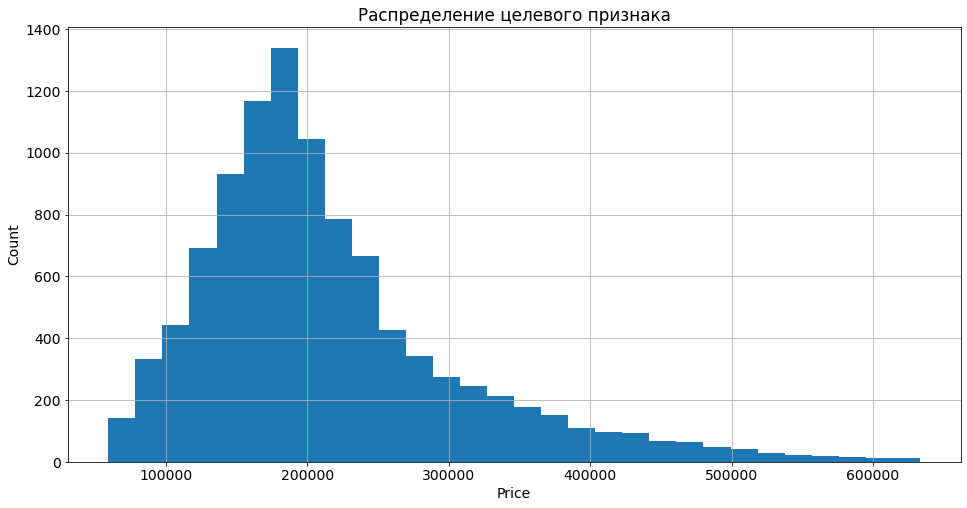

In [10]:
plt.figure(figsize = (16, 8))

train_df['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Распределение целевого признака')
plt.show()

### Анализ на наличие выбросов

In [11]:
numeric_cols = ['int16', 'float16', 'int8', 'int32', 'float32']
train_numeric = train_df.select_dtypes(include = numeric_cols)
train_numeric.drop('Price', axis='columns', inplace=True)
train_numeric.tail()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
9995,2.0,50.401787,30.476204,5.0,6,5.0,1968,0.135650,46,7960,6,350.0,3,11
9996,1.0,41.521545,20.539215,9.0,13,13.0,2000,0.000000,30,5562,0,NaN,0,5
9997,1.0,47.939007,NaN,1.0,12,16.0,2015,0.072158,2,629,1,NaN,0,0
9998,2.0,43.602562,33.840149,8.0,1,5.0,1961,0.307467,30,5048,9,325.0,2,5
9999,1.0,38.666645,21.157875,8.0,7,17.0,1990,0.000000,27,4798,0,30.0,2,8


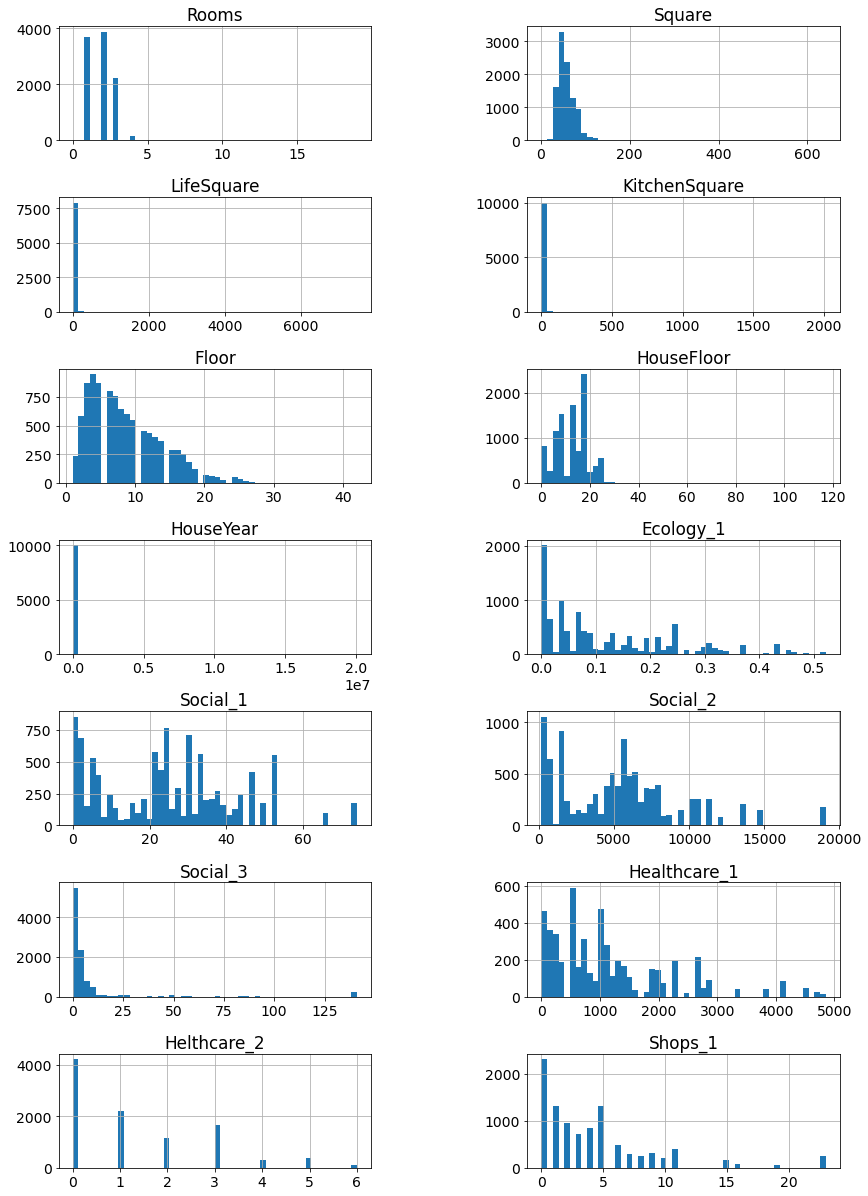

In [12]:
fig, axes = plt.subplots(nrows=7,ncols=2)

for col, axis in zip(train_numeric.columns, axes.flatten()):
    train_numeric.hist(column=col, bins=50, ax=axis)
    
fig.set_size_inches(14, 21)
plt.subplots_adjust(wspace=0.5, hspace=0.5)

In [13]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315712,37.199596,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300,214139.218750
std,0.839523,21.058718,86.241112,28.561113,5.241148,6.776192,2.005003e+05,0.119026,17.532614,4006.799803,23.831875,1021.518982,1.493601,4.806341,92872.304688
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,1.000000,41.774879,22.769833,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906
50%,2.000000,52.513309,32.781261,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,2.000000,65.900627,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938
max,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


## 3. Обработка данных

### 3.1 Выбросы

#### Признак Rooms

In [14]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [15]:
# За выброс будем считать количество комнат > 6.

train_df['Rooms_outlier'] = 0
train_df.loc[(train_df['Rooms'] == 0) | (train_df['Rooms'] > 6), 'Rooms_outlier'] = 1

In [16]:
# Заменим данные в которых кол-во комнат указано 0 на 1

train_df.loc[train_df['Rooms'] == 0, 'Rooms'] = 1

In [17]:
# Заменим данные в которых кол-во комнат более 5 (выброс) на median.

train_df.loc[train_df['Rooms'] > 6, 'Rooms'] = train_df['Rooms'].median()
train_df['Rooms'].value_counts()

2.0    3883
1.0    3713
3.0    2235
4.0     150
5.0      18
6.0       1
Name: Rooms, dtype: int64

#### Признак KitchenSquare

In [18]:
train_df['KitchenSquare'].value_counts()

1.0       2460
8.0       1306
5.0       1169
10.0      1075
6.0       1038
9.0        843
0.0        697
7.0        609
12.0       249
11.0       233
13.0        67
14.0        51
4.0         39
15.0        31
3.0         22
16.0        16
20.0        14
17.0        12
19.0        11
18.0         6
2.0          4
22.0         3
41.0         2
112.0        2
25.0         2
43.0         2
51.0         2
37.0         2
32.0         2
30.0         2
58.0         2
72.0         1
96.0         1
66.0         1
48.0         1
40.0         1
2014.0       1
35.0         1
60.0         1
78.0         1
27.0         1
84.0         1
62.0         1
42.0         1
63.0         1
39.0         1
1970.0       1
36.0         1
75.0         1
26.0         1
21.0         1
29.0         1
23.0         1
73.0         1
123.0        1
31.0         1
53.0         1
54.0         1
Name: KitchenSquare, dtype: int64

In [19]:
# За выброс будем считать значения меньше 2 и больше 25
# Заменим параметры 'KitchenSquare' со значением больше 25, меньше 2 и NaN

condition = (train_df['KitchenSquare'].isna()) | (train_df['KitchenSquare'] > 25)
train_df.loc[condition, 'KitchenSquare'] = round((train_df['Square'] - train_df['LifeSquare']) / 2)

train_df.loc[train_df['KitchenSquare'] > 25, 'KitchenSquare'] = 25

train_df.loc[(train_df['KitchenSquare'] < 2), 'KitchenSquare'] = 2

train_df.loc[train_df['KitchenSquare'].isna(), 'KitchenSquare'] = train_df['KitchenSquare'].median()

train_df['KitchenSquare'].value_counts()

2.0     3180
8.0     1307
5.0     1169
10.0    1078
6.0     1040
9.0      845
7.0      609
12.0     249
11.0     233
13.0      67
14.0      51
4.0       39
15.0      31
3.0       22
16.0      17
20.0      15
17.0      14
19.0      11
25.0       9
18.0       6
22.0       4
21.0       3
23.0       1
Name: KitchenSquare, dtype: int64

#### Признак HouseYear

In [20]:
train_df['HouseYear'].value_counts()

1977        2652
2017         308
2016         305
2015         299
2014         210
            ... 
1947           1
1916           1
1910           1
1928           1
20052011       1
Name: HouseYear, Length: 97, dtype: int64

In [21]:
# За вброс будем считать значения больше 2021
# Заменим параметры больше 2021 на 2021

train_df.loc[train_df['HouseYear'] > 2021, 'HouseYear'] = 2021

#### Признаки HouseFloor, Floor

In [22]:
train_df['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.],
      dtype=float32)

In [23]:
train_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=int8)

In [24]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

1825

In [25]:
train_df['HouseFloor_outlier'] = 0
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
train_df.loc[train_df['Floor'] > train_df['HouseFloor'], 'HouseFloor_outlier'] = 1

train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].median()

In [26]:
floor_outliers = train_df.loc[train_df['Floor'] > train_df['HouseFloor']].index
floor_outliers

Int64Index([   7,   14,   16,   21,   26,   35,   39,   44,   51,   67,
            ...
            9959, 9962, 9971, 9973, 9975, 9984, 9985, 9989, 9991, 9995],
           dtype='int64', length=1610)

In [27]:
train_df.loc[floor_outliers, 'Floor'] = train_df.loc[floor_outliers, 'HouseFloor']\
                                                .apply(lambda x: random.randint(1, x))

In [28]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

0

### 3.2 Пропуски

In [29]:
train_df.isna().sum()

Id                       0
DistrictId               0
Rooms                    0
Square                   0
LifeSquare            2113
KitchenSquare            0
Floor                    0
HouseFloor               0
HouseYear                0
Ecology_1                0
Ecology_2                0
Ecology_3                0
Social_1                 0
Social_2                 0
Social_3                 0
Healthcare_1          4798
Helthcare_2              0
Shops_1                  0
Shops_2                  0
Price                    0
Rooms_outlier            0
HouseFloor_outlier       0
dtype: int64

#### Признак LifeSquare

In [30]:
train_df['LifeSquare_nan'] = train_df['LifeSquare'].isna() * 1

condition = (train_df['LifeSquare'].isna()) \
             & (~train_df['Square'].isna()) \
             & (~train_df['KitchenSquare'].isna())
        
train_df.loc[condition, 'LifeSquare'] = train_df.loc[condition, 'Square'] \
                                            - train_df.loc[condition, 'KitchenSquare'] - 2

In [31]:
train_df['LifeSquare'].median()

36.16924285888672

#### Признак Healthcare_1

In [32]:
train_df.drop('Healthcare_1', axis=1, inplace=True)

train_df.isna().sum()

Id                    0
DistrictId            0
Rooms                 0
Square                0
LifeSquare            0
KitchenSquare         0
Floor                 0
HouseFloor            0
HouseYear             0
Ecology_1             0
Ecology_2             0
Ecology_3             0
Social_1              0
Social_2              0
Social_3              0
Helthcare_2           0
Shops_1               0
Shops_2               0
Price                 0
Rooms_outlier         0
HouseFloor_outlier    0
LifeSquare_nan        0
dtype: int64

#### Подготовка данных

In [33]:
class DataPreprocessing:

    def __init__(self):
        """Параметры класса"""
        self.medians=None
        self.kitchen_square_quantile = None
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
        self.kitchen_square_quantile = X['KitchenSquare'].quantile(.975)
    
    def transform(self, X):
        """Трансформация данных"""

        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] > 6), 'Rooms_outlier'] = 1
        
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] > 6, 'Rooms'] = self.medians['Rooms']
        
        # KitchenSquare
        condition = (X['KitchenSquare'].isna()) \
                    | (X['KitchenSquare'] > self.kitchen_square_quantile)
        
        X.loc[condition, 'KitchenSquare'] = self.medians['KitchenSquare']

        X.loc[X['KitchenSquare'] < 2, 'KitchenSquare'] = 2
        
        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        
        floor_outliers = X.loc[X['Floor'] > X['HouseFloor']].index
        X.loc[floor_outliers, 'Floor'] = X.loc[floor_outliers, 'HouseFloor']\
                                            .apply(lambda x: random.randint(1, x))
        
        # HouseYear
        current_year = datetime.now().year
        
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        
        # Healthcare_1
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)
            
        # LifeSquare
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        condition = (X['LifeSquare'].isna()) & \
                      (~X['Square'].isna()) & \
                      (~X['KitchenSquare'].isna())
        
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] - 2
        
        
        X.fillna(self.medians, inplace=True)
        
        return X

### 3.3 Построение новых признаков

#### Признак Dummies

In [34]:
binary_to_numbers = {'A': 0, 'B': 1}

train_df['Ecology_2'] = train_df['Ecology_2'].replace(binary_to_numbers)
train_df['Ecology_3'] = train_df['Ecology_3'].replace(binary_to_numbers)
train_df['Shops_2'] = train_df['Shops_2'].replace(binary_to_numbers)

#### Признаки DistrictSize, IsDistrictLarge

In [35]:
district_size = train_df['DistrictId'].value_counts().reset_index()\
                    .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size.head()

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294


In [36]:
train_df = train_df.merge(district_size, on='DistrictId', how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,DistrictSize
0,14038,35,2.0,47.981560,29.442751,6.0,7,9.0,1969,0.089040,...,7976,5,0,11,1,184966.937500,0,0,0,22
1,15053,41,3.0,65.683640,40.049541,8.0,7,9.0,1978,0.000070,...,10309,1,1,16,1,300009.437500,0,0,0,87
2,4765,53,2.0,44.947952,29.197611,2.0,8,12.0,1968,0.049637,...,7759,0,1,3,1,220925.906250,0,0,0,174
3,5809,58,2.0,53.352982,52.731510,9.0,8,17.0,1977,0.437885,...,5735,3,0,5,1,175616.234375,0,0,0,179
4,10783,99,1.0,39.649193,23.776169,7.0,11,12.0,1976,0.012339,...,5776,1,2,4,1,150226.531250,0,0,0,97


In [37]:
(train_df['DistrictSize'] > 100).value_counts()

True     5069
False    4931
Name: DistrictSize, dtype: int64

In [38]:
train_df['IsDistrictLarge'] = (train_df['DistrictSize'] > 100).astype(int)

#### Признак MedPriceByFloorYear

In [39]:
def floor_to_cat(X):

    X['floor_cat'] = 0

    X.loc[X['Floor'] <= 3, 'floor_cat'] = 1  
    X.loc[(X['Floor'] > 3) & (X['Floor'] <= 5), 'floor_cat'] = 2
    X.loc[(X['Floor'] > 5) & (X['Floor'] <= 9), 'floor_cat'] = 3
    X.loc[(X['Floor'] > 9) & (X['Floor'] <= 15), 'floor_cat'] = 4
    X.loc[X['Floor'] > 15, 'floor_cat'] = 5

    return X


def floor_to_cat_pandas(X):
    bins = [0, 3, 5, 9, 15, X['Floor'].max()]
    X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)
    
    X['floor_cat'].fillna(-1, inplace=True)
    return X


def year_to_cat(X):

    X['year_cat'] = 0

    X.loc[X['HouseYear'] <= 1941, 'year_cat'] = 1
    X.loc[(X['HouseYear'] > 1941) & (X['HouseYear'] <= 1945), 'year_cat'] = 2
    X.loc[(X['HouseYear'] > 1945) & (X['HouseYear'] <= 1980), 'year_cat'] = 3
    X.loc[(X['HouseYear'] > 1980) & (X['HouseYear'] <= 2000), 'year_cat'] = 4
    X.loc[(X['HouseYear'] > 2000) & (X['HouseYear'] <= 2010), 'year_cat'] = 5
    X.loc[(X['HouseYear'] > 2010), 'year_cat'] = 6

    return X


def year_to_cat_pandas(X):
    bins = [0, 1941, 1945, 1980, 2000, 2010, X['HouseYear'].max()]
    X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)
    
    X['year_cat'].fillna(-1, inplace=True)
    return X

In [40]:
bins = [0, 3, 5, 9, 15, train_df['Floor'].max()]
pd.cut(train_df['Floor'], bins=bins, labels=False)

0       2
1       2
2       2
3       2
4       3
       ..
9995    0
9996    3
9997    3
9998    0
9999    2
Name: Floor, Length: 10000, dtype: int64

In [41]:
bins = [0, 3, 5, 9, 15, train_df['Floor'].max()]
pd.cut(train_df['Floor'], bins=bins)

0        (5, 9]
1        (5, 9]
2        (5, 9]
3        (5, 9]
4       (9, 15]
         ...   
9995     (0, 3]
9996    (9, 15]
9997    (9, 15]
9998     (0, 3]
9999     (5, 9]
Name: Floor, Length: 10000, dtype: category
Categories (5, interval[int64]): [(0, 3] < (3, 5] < (5, 9] < (9, 15] < (15, 42]]

In [42]:
train_df = year_to_cat(train_df)
train_df = floor_to_cat(train_df)
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,DistrictSize,IsDistrictLarge,year_cat,floor_cat
0,14038,35,2.0,47.981560,29.442751,6.0,7,9.0,1969,0.089040,...,11,1,184966.937500,0,0,0,22,0,3,3
1,15053,41,3.0,65.683640,40.049541,8.0,7,9.0,1978,0.000070,...,16,1,300009.437500,0,0,0,87,0,3,3
2,4765,53,2.0,44.947952,29.197611,2.0,8,12.0,1968,0.049637,...,3,1,220925.906250,0,0,0,174,1,3,3
3,5809,58,2.0,53.352982,52.731510,9.0,8,17.0,1977,0.437885,...,5,1,175616.234375,0,0,0,179,1,3,3
4,10783,99,1.0,39.649193,23.776169,7.0,11,12.0,1976,0.012339,...,4,1,150226.531250,0,0,0,97,0,3,4


In [43]:
med_price_by_floor_year = train_df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
med_price_by_floor_year.head()

,year_cat,floor_cat,MedPriceByFloorYear
0,1,1,366272.03125
1,1,2,324303.81250
2,1,3,421756.28125
3,1,4,274992.46875
4,2,1,467230.53125


In [44]:
train_df = train_df.merge(med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,DistrictSize,IsDistrictLarge,year_cat,floor_cat,MedPriceByFloorYear
0,14038,35,2.0,47.981560,29.442751,6.0,7,9.0,1969,0.089040,...,1,184966.937500,0,0,0,22,0,3,3,191935.171875
1,15053,41,3.0,65.683640,40.049541,8.0,7,9.0,1978,0.000070,...,1,300009.437500,0,0,0,87,0,3,3,191935.171875
2,4765,53,2.0,44.947952,29.197611,2.0,8,12.0,1968,0.049637,...,1,220925.906250,0,0,0,174,1,3,3,191935.171875
3,5809,58,2.0,53.352982,52.731510,9.0,8,17.0,1977,0.437885,...,1,175616.234375,0,0,0,179,1,3,3,191935.171875
4,10783,99,1.0,39.649193,23.776169,7.0,11,12.0,1976,0.012339,...,1,150226.531250,0,0,0,97,0,3,4,183842.750000


#### Подготовка новых данных

In [45]:
class FeatureGenetator():
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        self.house_year_max = None
        self.floor_max = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
                
        # Target encoding
        ## District, Rooms
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            
            self.med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'MedPriceByDistrict'})
            
            self.med_price_by_district_median = self.med_price_by_district['MedPriceByDistrict'].median()
            
        ## floor, year
        if y is not None:
            self.floor_max = df['Floor'].max()
            self.house_year_max = df['HouseYear'].max()
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
            self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()
        

        
    def transform(self, X):
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        X['new_district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new_district'] = 1
        
        X['DistrictSize'].fillna(5, inplace=True)
        
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        
        # More categorical features
        X = self.floor_to_cat(X)  # + столбец floor_cat
        X = self.year_to_cat(X)   # + столбец year_cat
        
        # Target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
            X.fillna(self.med_price_by_district_median, inplace=True)
            
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
            X.fillna(self.med_price_by_floor_year_median, inplace=True)
        
        return X
    
    def floor_to_cat(self, X):
        bins = [0, 3, 5, 9, 15, self.floor_max]
        X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)

        X['floor_cat'].fillna(-1, inplace=True) 
        return X
     
    def year_to_cat(self, X):
        bins = [0, 1941, 1945, 1980, 2000, 2010, self.house_year_max]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)

        X['year_cat'].fillna(-1, inplace=True)
        return X

## 4. Отбор признаков

In [46]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Rooms_outlier',
 'HouseFloor_outlier',
 'LifeSquare_nan',
 'DistrictSize',
 'IsDistrictLarge',
 'year_cat',
 'floor_cat',
 'MedPriceByFloorYear']

In [47]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
                 'Helthcare_2', 'Shops_1', 'Shops_2']

new_feature_names = ['Rooms_outlier', 'HouseFloor_outlier', 'HouseYear_outlier', 'LifeSquare_nan', 'DistrictSize',
                     'new_district', 'IsDistrictLarge',  'MedPriceByDistrict', 'MedPriceByFloorYear']

target_name = 'Price'

In [48]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Rooms_outlier',
 'HouseFloor_outlier',
 'LifeSquare_nan',
 'DistrictSize',
 'IsDistrictLarge',
 'year_cat',
 'floor_cat',
 'MedPriceByFloorYear']

## 5. Разбиение на train и test

In [49]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [50]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.30, shuffle=True, random_state=21)

In [51]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((7000, 22), (3000, 22), (5000, 22))

In [52]:
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((7000, 29), (3000, 29), (5000, 29))

In [53]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

In [54]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

## 6. Построение модели

### Обучение 

In [55]:
gb_model = GradientBoostingRegressor(random_state=21, criterion='mse')
gb_model.fit(X_train, y_train)

GradientBoostingRegressor(criterion='mse', random_state=21)

### Оценка модели

Train R2:	0.802
Test R2:	0.681


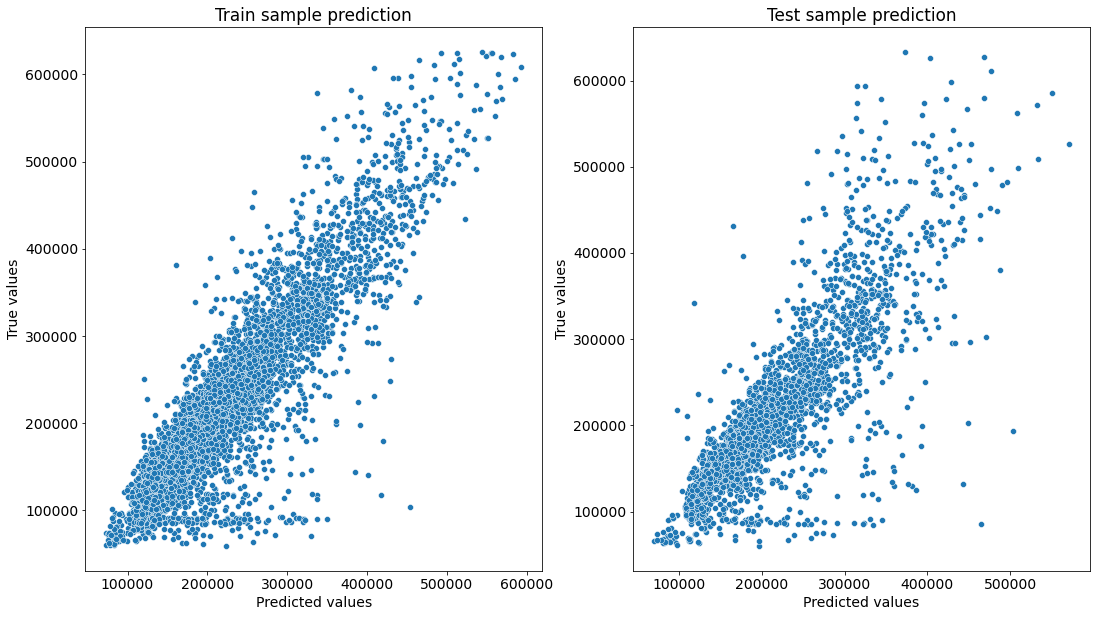

In [56]:
y_train_preds = gb_model.predict(X_train)
y_test_preds = gb_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

### Прогноз

In [57]:
X_test_pred = test_df.loc[:,['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
                 'Helthcare_2', 'Shops_1', 'Shops_2', 'Rooms_outlier', 'HouseFloor_outlier', 'HouseYear_outlier', 'LifeSquare_nan', 'DistrictSize',
                     'new_district', 'IsDistrictLarge',  'MedPriceByDistrict', 'MedPriceByFloorYear']]
X_test_pred.head(5)

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,...,Shops_2,Rooms_outlier,HouseFloor_outlier,HouseYear_outlier,LifeSquare_nan,DistrictSize,new_district,IsDistrictLarge,MedPriceByDistrict,MedPriceByFloorYear
0,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,1,1,...,1,0,0,0,0,112.0,0,1,165280.953514,192761.992851
1,2.0,69.263183,65.263183,2.0,1,1.0,1977,0.075779,1,1,...,1,0,1,0,1,83.0,0,0,242298.108379,180185.219437
2,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,1,1,...,1,0,0,0,0,3.0,0,0,244361.195598,380359.112959
3,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,1,1,...,1,0,0,0,0,68.0,0,0,228429.186273,234614.242198
4,1.0,47.527111,43.387569,2.0,17,17.0,2017,0.072158,1,1,...,0,0,0,0,0,610.0,0,1,117705.264213,222063.618812


In [58]:
cols_scale = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Social_1', 'Social_2', 'Social_3', 'Shops_1', 'DistrictSize']
X_test_pred.loc[:, cols_scale]

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Shops_1,DistrictSize
0,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,11,2748,1,0,112.0
1,2.0,69.263183,65.263183,2.0,1,1.0,1977,0.075779,6,1437,3,2,83.0
2,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,30,7538,87,5,3.0
3,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,23,4583,3,3,68.0
4,1.0,47.527111,43.387569,2.0,17,17.0,2017,0.072158,2,629,1,0,610.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,3.0,67.133911,50.809797,6.0,5,9.0,1973,0.000170,36,5992,0,1,92.0
4996,1.0,40.198472,21.807061,10.0,12,17.0,2017,0.007122,1,264,0,1,459.0
4997,3.0,77.842178,48.282625,9.0,22,22.0,1989,0.090799,74,19083,2,15,42.0
4998,2.0,81.305222,77.305222,2.0,4,14.0,1977,0.072158,2,629,1,0,160.0


In [59]:
y_test_preds = gb_model.predict(X_test_pred)
test_df['Price'] = y_test_preds
test_df.head(10)

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,...,Rooms_outlier,HouseFloor_outlier,HouseYear_outlier,LifeSquare_nan,DistrictSize,new_district,IsDistrictLarge,MedPriceByDistrict,MedPriceByFloorYear,Price
0,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,1,1,...,0,0,0,0,112.0,0,1,165280.953514,192761.992851,158364.396562
1,2.0,69.263183,65.263183,2.0,1,1.0,1977,0.075779,1,1,...,0,1,0,1,83.0,0,0,242298.108379,180185.219437,254506.182776
2,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,1,1,...,0,0,0,0,3.0,0,0,244361.195598,380359.112959,142717.498639
3,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,1,1,...,0,0,0,0,68.0,0,0,228429.186273,234614.242198,314849.791126
4,1.0,47.527111,43.387569,2.0,17,17.0,2017,0.072158,1,1,...,0,0,0,0,610.0,0,1,117705.264213,222063.618812,129711.802152
5,1.0,40.675627,36.675627,2.0,21,21.0,1977,0.049637,1,1,...,0,0,0,1,114.0,0,1,190958.655767,175836.385259,197681.401067
6,2.0,68.099538,64.843025,2.0,2,17.0,1977,0.075779,1,1,...,0,0,0,0,391.0,0,1,143449.944701,180185.219437,157021.111956
7,2.0,48.193897,32.857644,6.0,5,14.0,1972,0.135650,1,1,...,0,0,0,0,21.0,0,0,233235.794794,188642.277553,219180.081758
8,3.0,72.277106,45.968758,9.0,17,17.0,1997,0.041116,1,1,...,0,0,0,0,46.0,0,0,308119.396425,268536.842532,313249.558821
9,3.0,80.219400,47.660260,9.0,13,17.0,2014,0.243205,1,1,...,0,0,0,0,344.0,0,1,215477.253159,177939.063412,204888.280677


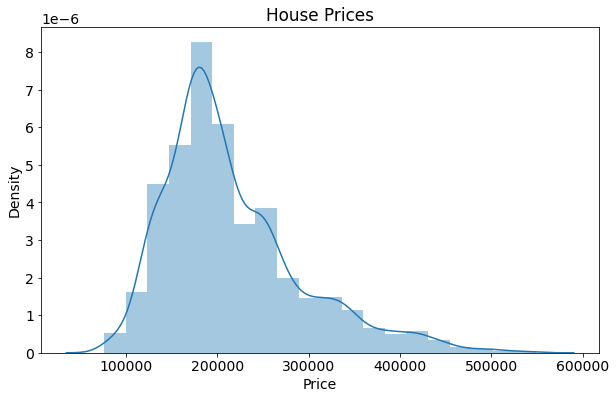

In [60]:
plt.figure(figsize = (10, 6))

sns.distplot(test_df['Price'], bins=20) 

y = np.linspace(0, 0.000005, 10)

plt.title('House Prices')
plt.show()

In [61]:
result = './PrusakovVV_predictions.csv'
test_df.to_csv(result, index=False, encoding='utf-8')